In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

In [3]:
INTC = pd.read_csv("/content/drive/MyDrive/DS340W/INTC.csv")
AMD = pd.read_csv("/content/drive/MyDrive/DS340W/AMD.csv")
NVDA = pd.read_csv("/content/drive/MyDrive/DS340W/NVDA.csv")

In [4]:
def Dataset(Data, Date):

  Train_Data = Data['Open'][Data['Date'] < Date].to_numpy()
  Data_Train = []
  Data_Train_X = []
  Data_Train_Y = []
  for i in range(0, len(Train_Data), 5):
    try:
      Data_Train.append(Train_Data[i : i + 5])
    except:
      pass

  if len(Data_Train[-1]) < 5:
    Data_Train.pop(-1)
  
  Data_Train_X = Data_Train[0 : -1]
  Data_Train_X = np.array(Data_Train_X)
  Data_Train_X = Data_Train_X.reshape((-1, 5, 1))
  Data_Train_Y = Data_Train[1 : len(Data_Train)]
  Data_Train_Y = np.array(Data_Train_Y)
  Data_Train_Y = Data_Train_Y.reshape((-1, 5, 1))


  Test_Data = Data['Open'][Data['Date'] >= Date].to_numpy()
  Data_Test = []
  Data_Test_X = []
  Data_Test_Y = []
  for i in range(0, len(Test_Data), 5):
    try:
      Data_Test.append(Test_Data[i : i + 5])
    except:
      pass

  if len(Data_Test[-1]) < 5:
    Data_Test.pop(-1)
  
  Data_Test_X = Data_Test[0 : -1]
  Data_Test_X = np.array(Data_Test_X)
  Data_Test_X = Data_Test_X.reshape((-1, 5, 1))
  Data_Test_Y = Data_Test[1 : len(Data_Test)]
  Data_Test_Y = np.array(Data_Test_Y)
  Data_Test_Y = Data_Test_Y.reshape((-1, 5, 1))

  return Data_Train_X, Data_Train_Y, Data_Test_X, Data_Test_Y

In [5]:
def Model():
  model = tf.keras.models.Sequential([
                                      tf.keras.layers.LSTM(200, input_shape = (5, 1), activation = tf.nn.leaky_relu, return_sequences = True),
                                      tf.keras.layers.LSTM(200, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(200, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(100, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(50, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(25, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(10, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(5, activation = tf.nn.leaky_relu)
                                      ])
  return model

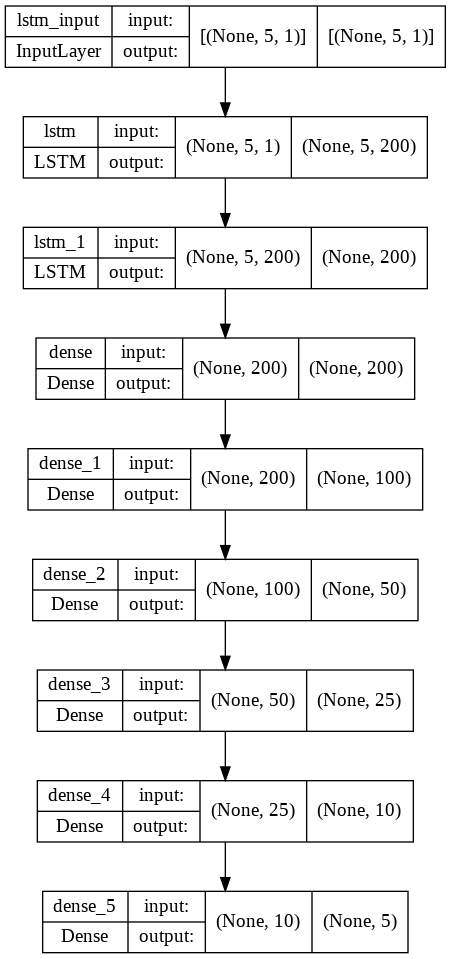

In [6]:
model = Model()
tf.keras.utils.plot_model(model, show_shapes = True)

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 200)            161600    
                                                                 
 lstm_1 (LSTM)               (None, 200)               320800    
                                                                 
 dense (Dense)               (None, 200)               40200     
                                                                 
 dense_1 (Dense)             (None, 100)               20100     
                                                                 
 dense_2 (Dense)             (None, 50)                5050      
                                                                 
 dense_3 (Dense)             (None, 25)                1275      
                                                                 
 dense_4 (Dense)             (None, 10)                2

In [8]:
def scheduler(epoch):
  
  if epoch <= 150:
    lrate = (10 ** -5) * (epoch / 150) 
  elif epoch <= 400:
    initial_lrate = (10 ** -5)
    k = 0.01
    lrate = initial_lrate * math.exp(-k * (epoch - 150))
  else:
    lrate = (10 ** -6)
  
  return lrate

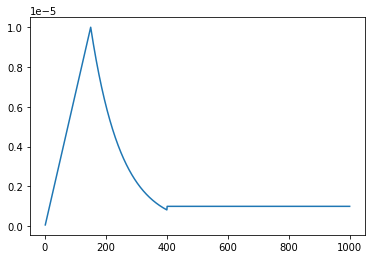

In [9]:
epochs = [i for i in range(1, 1001, 1)]
lrate = [scheduler(i) for i in range(1, 1001, 1)]
plt.plot(epochs, lrate)

In [10]:
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

# AMD

In [11]:
print(AMD.head())

         Date      Open      High       Low   Close  Adj Close    Volume
0  2000-01-03  14.96875  15.59375  14.68750  15.500     15.500   7843200
1  2000-01-04  15.12500  15.50000  14.59375  14.625     14.625   6290200
2  2000-01-05  14.53125  15.06250  14.00000  15.000     15.000   8204600
3  2000-01-06  15.50000  16.00000  15.25000  16.000     16.000  11489400
4  2000-01-07  15.40625  16.40625  15.37500  16.250     16.250   8543400


In [12]:
print(AMD.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5585 entries, 0 to 5584
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5585 non-null   object 
 1   Open       5585 non-null   float64
 2   High       5585 non-null   float64
 3   Low        5585 non-null   float64
 4   Close      5585 non-null   float64
 5   Adj Close  5585 non-null   float64
 6   Volume     5585 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 305.6+ KB
None


In [13]:
AMD['Date'] = pd.to_datetime(AMD['Date'])

In [14]:
# Split into training and testing set
split_date = '2013-12-31'
AMD_TRAIN_X, AMD_TRAIN_Y, AMD_TEST_X, AMD_TEST_Y = Dataset(AMD, split_date)

In [15]:
AMD_model = Model()
AMD_model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())

In [16]:
AMD_hist = AMD_model.fit(AMD_TRAIN_X, AMD_TRAIN_Y, epochs = 1000, validation_data = (AMD_TEST_X, AMD_TEST_Y), callbacks=[callback])

Epoch 1/1000
22/22 [==============================] - 16s 188ms/step - loss: 249.2703 - root_mean_squared_error: 15.7883 - val_loss: 2374.9570 - val_root_mean_squared_error: 48.7335 - lr: 0.0000e+00
Epoch 2/1000
22/22 [==============================] - 2s 95ms/step - loss: 249.2671 - root_mean_squared_error: 15.7882 - val_loss: 2374.8684 - val_root_mean_squared_error: 48.7326 - lr: 6.6667e-08
Epoch 3/1000
22/22 [==============================] - 2s 99ms/step - loss: 249.2568 - root_mean_squared_error: 15.7879 - val_loss: 2374.6816 - val_root_mean_squared_error: 48.7307 - lr: 1.3333e-07
Epoch 4/1000
22/22 [==============================] - 2s 98ms/step - loss: 249.2393 - root_mean_squared_error: 15.7873 - val_loss: 2374.4011 - val_root_mean_squared_error: 48.7278 - lr: 2.0000e-07
Epoch 5/1000
22/22 [==============================] - 2s 104ms/step - loss: 249.2143 - root_mean_squared_error: 15.7865 - val_loss: 2374.0110 - val_root_mean_squared_error: 48.7238 - lr: 2.6667e-07
Epoch 6/1000

In [17]:
history_dict = AMD_hist.history

loss = history_dict["loss"]
root_mean_squared_error = history_dict["root_mean_squared_error"]
val_loss = history_dict["val_loss"]
val_root_mean_squared_error = history_dict["val_root_mean_squared_error"]

epochs = range(1, len(loss) + 1)

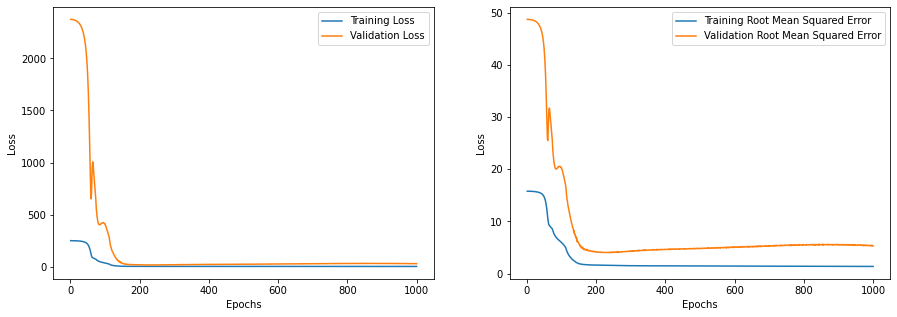

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs, loss, label = 'Training Loss')
ax1.plot(epochs, val_loss, label = 'Validation Loss')
ax1.set(xlabel = "Epochs", ylabel = "Loss")
ax1.legend()

ax2.plot(epochs, root_mean_squared_error, label = "Training Root Mean Squared Error")
ax2.plot(epochs, val_root_mean_squared_error, label = "Validation Root Mean Squared Error")
ax2.set(xlabel = "Epochs", ylabel = "Loss")
ax2.legend()

plt.show()

In [19]:
print(AMD_TEST_X)

[[[  3.87    ]
  [  3.85    ]
  [  3.98    ]
  [  4.01    ]
  [  4.19    ]]

 [[  4.23    ]
  [  4.2     ]
  [  4.09    ]
  [  4.19    ]
  [  4.14    ]]

 [[  4.34    ]
  [  4.5     ]
  [  4.15    ]
  [  4.31    ]
  [  3.79    ]]

 ...

 [[115.510002]
  [117.190002]
  [119.050003]
  [116.260002]
  [113.900002]]

 [[115.269997]
  [117.400002]
  [104.559998]
  [117.160004]
  [120.309998]]

 [[122.330002]
  [115.470001]
  [118.129997]
  [112.      ]
  [108.529999]]]


(2060,)


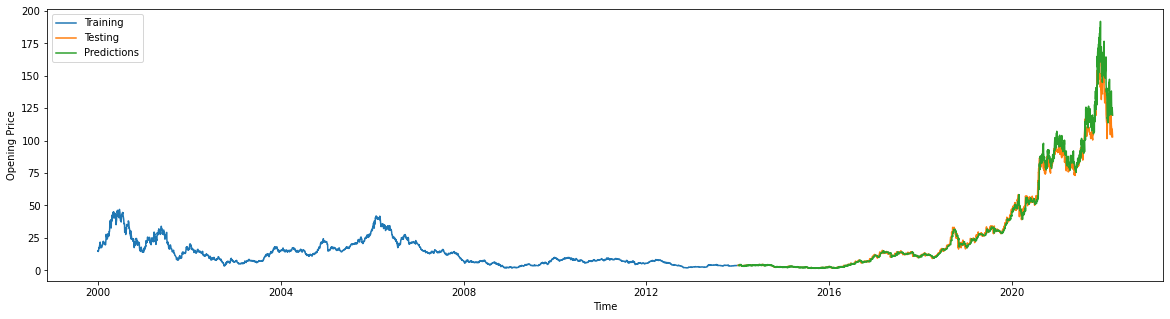

In [25]:
AMD_prediction = AMD_model.predict(AMD_TEST_X)
print(AMD_prediction.reshape(-1).shape)
plt.figure(figsize=(20, 5))
plt.plot(AMD['Date'][AMD['Date'] < '2013-12-31'], AMD['Open'][AMD['Date'] < '2013-12-31'], label = 'Training')
plt.plot(AMD['Date'][AMD['Date'] > '2013-12-31'], AMD['Open'][AMD['Date'] > '2013-12-31'], label = 'Testing')
plt.plot(AMD['Date'][AMD['Date'] > '2014-01-07'], AMD_prediction.reshape(-1), label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Opening Price')
plt.legend(loc = 'best')

In [26]:
rmse = math.sqrt(mean_squared_error(AMD_TEST_Y.reshape(-1, 5), AMD_prediction))
mape = np.mean(np.abs(AMD_prediction - AMD_TEST_Y.reshape(-1, 5))/np.abs(AMD_TEST_Y.reshape(-1, 5)))
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

RMSE: 5.268592334314419
MAPE: 0.07214586466057164


# INTC

In [27]:
print(INTC.head())

         Date       Open     High       Low     Close  Adj Close    Volume
0  2000-01-03  41.632813  43.6875  41.62500  43.50000  26.448721  57710200
1  2000-01-04  42.718750  43.9375  41.12500  41.46875  25.213692  51019600
2  2000-01-05  41.500000  42.9375  40.25000  41.81250  25.422688  52389000
3  2000-01-06  40.875000  41.6875  39.09375  39.37500  23.940651  55171200
4  2000-01-07  38.750000  41.0000  38.68750  41.00000  24.928686  41096400


In [29]:
print(INTC.info)

<bound method DataFrame.info of             Date       Open       High        Low      Close  Adj Close  \
0     2000-01-03  41.632813  43.687500  41.625000  43.500000  26.448721   
1     2000-01-04  42.718750  43.937500  41.125000  41.468750  25.213692   
2     2000-01-05  41.500000  42.937500  40.250000  41.812500  25.422688   
3     2000-01-06  40.875000  41.687500  39.093750  39.375000  23.940651   
4     2000-01-07  38.750000  41.000000  38.687500  41.000000  24.928686   
...          ...        ...        ...        ...        ...        ...   
5580  2022-03-08  47.689999  48.720001  46.889999  47.500000  47.500000   
5581  2022-03-09  48.410000  48.459999  46.889999  47.630001  47.630001   
5582  2022-03-10  47.290001  47.310001  46.160000  46.660000  46.660000   
5583  2022-03-11  47.150002  47.279999  45.770000  45.830002  45.830002   
5584  2022-03-14  45.900002  45.980000  44.299999  44.400002  44.400002   

        Volume  
0     57710200  
1     51019600  
2     52389000  

In [30]:
INTC['Date'] = pd.to_datetime(INTC['Date'])

In [31]:
INTC_TRAIN_X, INTC_TRAIN_Y, INTC_TEST_X, INTC_TEST_Y = Dataset(INTC, split_date)

In [32]:
INTC_model = Model()
INTC_model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())

In [33]:
INTC_hist = INTC_model.fit(INTC_TRAIN_X, INTC_TRAIN_Y, epochs = 500, validation_data = (INTC_TEST_X, INTC_TEST_Y), callbacks = [callback])

Epoch 1/500
22/22 [==============================] - 5s 80ms/step - loss: 733.1126 - root_mean_squared_error: 27.0761 - val_loss: 1980.4219 - val_root_mean_squared_error: 44.5019 - lr: 0.0000e+00
Epoch 2/500
22/22 [==============================] - 1s 48ms/step - loss: 733.1036 - root_mean_squared_error: 27.0759 - val_loss: 1980.3679 - val_root_mean_squared_error: 44.5013 - lr: 6.6667e-08
Epoch 3/500
22/22 [==============================] - 1s 50ms/step - loss: 733.0765 - root_mean_squared_error: 27.0754 - val_loss: 1980.2623 - val_root_mean_squared_error: 44.5001 - lr: 1.3333e-07
Epoch 4/500
22/22 [==============================] - 1s 49ms/step - loss: 733.0303 - root_mean_squared_error: 27.0745 - val_loss: 1980.1082 - val_root_mean_squared_error: 44.4984 - lr: 2.0000e-07
Epoch 5/500
22/22 [==============================] - 1s 43ms/step - loss: 732.9664 - root_mean_squared_error: 27.0734 - val_loss: 1979.9011 - val_root_mean_squared_error: 44.4961 - lr: 2.6667e-07
Epoch 6/500
22/22 [=

In [34]:
history_dict = INTC_hist.history

loss = history_dict["loss"]
root_mean_squared_error = history_dict["root_mean_squared_error"]
val_loss = history_dict["val_loss"]
val_root_mean_squared_error = history_dict["val_root_mean_squared_error"]

epochs = range(1, len(loss) + 1)

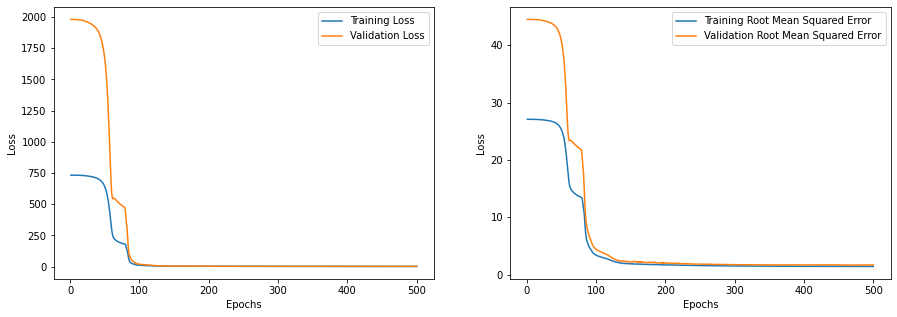

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs, loss, label = 'Training Loss')
ax1.plot(epochs, val_loss, label = 'Validation Loss')
ax1.set(xlabel = "Epochs", ylabel = "Loss")
ax1.legend()

ax2.plot(epochs, root_mean_squared_error, label = "Training Root Mean Squared Error")
ax2.plot(epochs, val_root_mean_squared_error, label = "Validation Root Mean Squared Error")
ax2.set(xlabel = "Epochs", ylabel = "Loss")
ax2.legend()

plt.show()

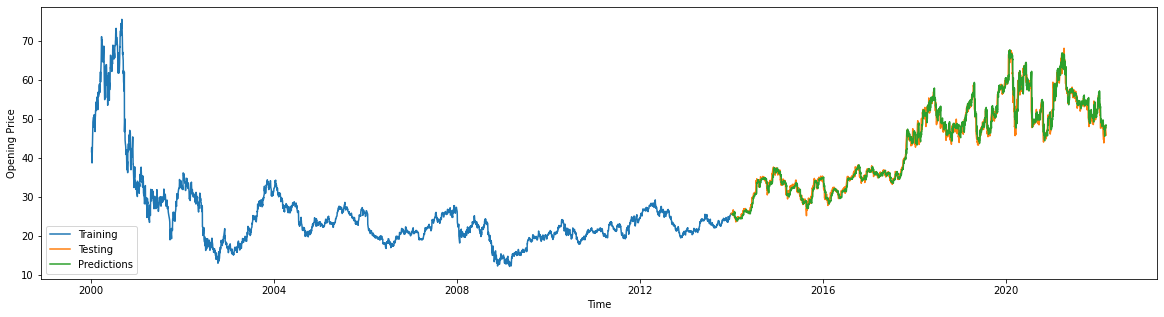

In [37]:
INTC_prediction = INTC_model.predict(INTC_TEST_X)

plt.figure(figsize=(20, 5))
plt.plot(INTC['Date'][INTC['Date'] < '2013-12-31'], INTC['Open'][INTC['Date'] < '2013-12-31'], label = 'Training')
plt.plot(INTC['Date'][INTC['Date'] >= '2013-12-30'], INTC['Open'][INTC['Date'] >= '2013-12-30'], label = 'Testing')
plt.plot(INTC['Date'][INTC['Date'] > '2014-01-07'], INTC_prediction.reshape(-1), label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Opening Price')
plt.legend(loc = 'best')

In [49]:
rmse = math.sqrt(mean_squared_error(INTC_TEST_Y.reshape(-1, 5), INTC_prediction))
mape = np.mean(np.abs(INTC_prediction - INTC_TEST_Y.reshape(-1, 5))/np.abs(INTC_TEST_Y.reshape(-1, 5)))
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

RMSE: 1.666450359447348
MAPE: 0.025482751556228894


# NVDA

In [ ]:
print(NVDA.head())

In [40]:
print(NVDA.info)

<bound method DataFrame.info of             Date        Open        High         Low       Close   Adj Close  \
0     2000-01-03    0.984375    0.992188    0.919271    0.975260    0.895793   
1     2000-01-04    0.958333    0.960938    0.901042    0.949219    0.871874   
2     2000-01-05    0.921875    0.937500    0.904948    0.917969    0.843170   
3     2000-01-06    0.917969    0.917969    0.822917    0.858073    0.788155   
4     2000-01-07    0.854167    0.881510    0.841146    0.872396    0.801311   
...          ...         ...         ...         ...         ...         ...   
5580  2022-03-08  213.089996  223.729996  206.500000  215.139999  215.139999   
5581  2022-03-09  223.869995  232.199997  222.470001  230.139999  230.139999   
5582  2022-03-10  225.309998  227.880005  218.820007  226.580002  226.580002   
5583  2022-03-11  230.220001  231.449997  220.460007  221.000000  221.000000   
5584  2022-03-14  218.690002  222.619995  211.589996  213.300003  213.300003   

       

In [41]:
NVDA['Date'] = pd.to_datetime(NVDA['Date'])

In [42]:
NVDA_TRAIN_X, NVDA_TRAIN_Y, NVDA_TEST_X, NVDA_TEST_Y = Dataset(NVDA, split_date)

In [43]:
NVDA_model = Model()
NVDA_model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())

In [44]:
NVDA_hist = NVDA_model.fit(NVDA_TRAIN_X, NVDA_TRAIN_Y, epochs = 750, validation_data = (INTC_TEST_X, INTC_TEST_Y), callbacks = [callback])

Epoch 1/750
22/22 [==============================] - 7s 102ms/step - loss: 13.6446 - root_mean_squared_error: 3.6939 - val_loss: 1981.3352 - val_root_mean_squared_error: 44.5122 - lr: 0.0000e+00
Epoch 2/750
22/22 [==============================] - 1s 43ms/step - loss: 13.6446 - root_mean_squared_error: 3.6939 - val_loss: 1981.3195 - val_root_mean_squared_error: 44.5120 - lr: 6.6667e-08
Epoch 3/750
22/22 [==============================] - 1s 43ms/step - loss: 13.6443 - root_mean_squared_error: 3.6938 - val_loss: 1981.2893 - val_root_mean_squared_error: 44.5117 - lr: 1.3333e-07
Epoch 4/750
22/22 [==============================] - 1s 42ms/step - loss: 13.6439 - root_mean_squared_error: 3.6938 - val_loss: 1981.2435 - val_root_mean_squared_error: 44.5112 - lr: 2.0000e-07
Epoch 5/750
22/22 [==============================] - 1s 43ms/step - loss: 13.6434 - root_mean_squared_error: 3.6937 - val_loss: 1981.1799 - val_root_mean_squared_error: 44.5104 - lr: 2.6667e-07
Epoch 6/750
22/22 [==========

In [45]:
history_dict = NVDA_hist.history

loss = history_dict["loss"]
root_mean_squared_error = history_dict["root_mean_squared_error"]
val_loss = history_dict["val_loss"]
val_root_mean_squared_error = history_dict["val_root_mean_squared_error"]

epochs = range(1, len(loss) + 1)

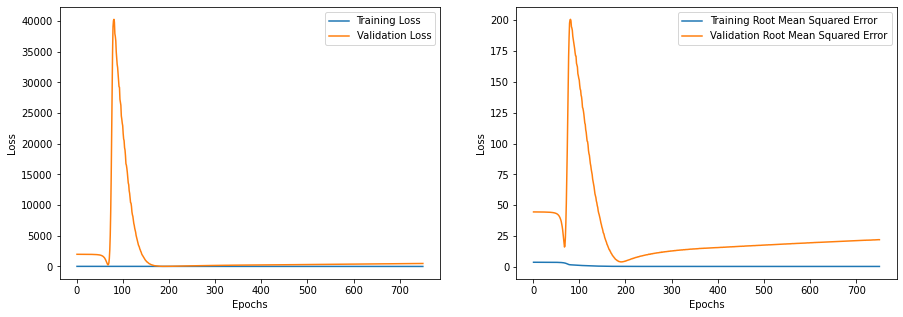

In [46]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs, loss, label = 'Training Loss')
ax1.plot(epochs, val_loss, label = 'Validation Loss')
ax1.set(xlabel = "Epochs", ylabel = "Loss")
ax1.legend()

ax2.plot(epochs, root_mean_squared_error, label = "Training Root Mean Squared Error")
ax2.plot(epochs, val_root_mean_squared_error, label = "Validation Root Mean Squared Error")
ax2.set(xlabel = "Epochs", ylabel = "Loss")
ax2.legend()

plt.show()

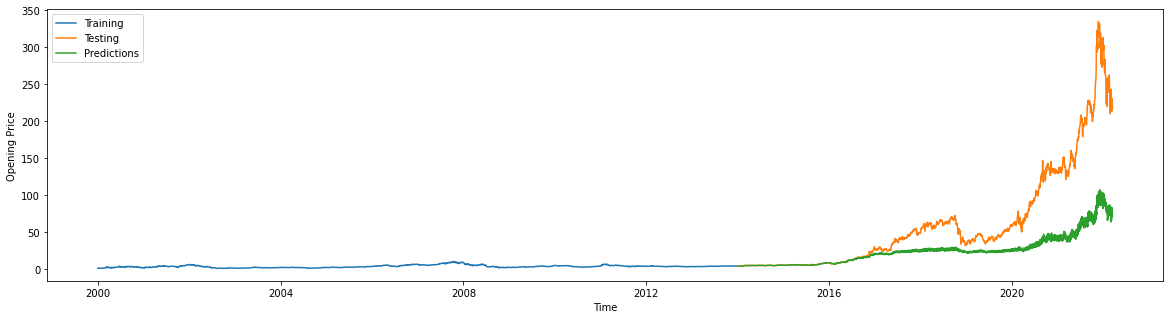

In [47]:
NVDA_prediction = NVDA_model.predict(NVDA_TEST_X)

plt.figure(figsize=(20, 5))
plt.plot(NVDA['Date'][NVDA['Date'] < '2013-12-31'], NVDA['Open'][NVDA['Date'] < '2013-12-31'], label = 'Training')
plt.plot(NVDA['Date'][NVDA['Date'] >= '2013-12-30'], NVDA['Open'][NVDA['Date'] >= '2013-12-30'], label = 'Testing')
plt.plot(NVDA['Date'][NVDA['Date'] > '2014-01-07'], NVDA_prediction.reshape(-1), label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Opening Price')
plt.legend(loc = 'best')

In [50]:
rmse = math.sqrt(mean_squared_error(NVDA_TEST_Y.reshape(-1, 5), NVDA_prediction))
mape = np.mean(np.abs(NVDA_prediction - NVDA_TEST_Y.reshape(-1, 5))/np.abs(NVDA_TEST_Y.reshape(-1, 5)))
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

RMSE: 63.14038519813241
MAPE: 0.366752504932161
